# Collective search on NK landscapes

Chapters represent parts of the final simulation
* Individual optimization
* Features for optimization
* Information sharing
* Decision making
* Social influence learning

In [2]:
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
import pickle

from scipy.stats.stats import pearsonr
# import seaborn as sns

In [3]:
class NK_landscape():
    
    def __init__(self, N=10, K=5, seed = None, C = None, dependencies = None):
        """
        Calculates a dictionary with values for every possible state. 
        Payoff is scaled form 0-1
        C: Table with values for every combination of connected components 
        fitness_dict: keys are the base10 converted states, values the fitness payoff 
        """
        assert N >= K+1
        
        self.N = N
        self.K = K
        
        self.rng = np.random.default_rng(seed) if seed is not None else np.random.default_rng(np.random.randint(0,100))
        if C is None or dependencies is None:
            self.initialize_C()
            self.initialize_dependencies()
        else:
            self.dependencies = dependencies
            self.C = C

        
        self.combinations = np.array(list(product([0,1], repeat=K+1)))
        self.max_value = None
        self.min_value = None
        
        self.fitness_dict = {}
        self.init_values()
        
    
    def initialize_dependencies(self):
        """[:,0] is connected with [:,1] --> [0,1] would mean node 0 has fluence on node 1"""
        depend = np.zeros((self.N, self.K+1))
        x = np.arange(self.N)
        depend[:,0] = x
        for _ in range(self.K):
            depend[:,_+1] = np.roll(x,_+1)  # TODO: Create random connections between dimensions

        self.dependencies = depend.astype(int)
    
    def initialize_C(self):
        self.C = self.rng.random((self.N,2**(self.K+1))).round(1)

    def f(self, state):
        """Checks all connected dimensions for the combination they are currently in and adds the value"""
        assert len(state) == self.N
        solution = np.empty(len(state))
        for i in range(len(self.dependencies)): 
            solution[i] = self.C[i, int("".join(map(str, state[self.dependencies[i]])), 2)]
        return round(solution.mean(), 2)
    
    def init_values(self):
        """Creates a dictionary mapping all states to their payoff"""
        max_val = 0
        min_val = 2
        for sol in np.array(list(product([0,1], repeat=self.N))):
            key = int("".join(map(str, sol)), 2)
            value = self.f(sol)
            self.fitness_dict[key] = value
          
            if max_val < value:
                max_val = value
            if min_val > value:
                min_val = value
        self.max_value = max_val
        self.min_value = min_val
        
    
    def get_scaled_fitness_new_calculation(self, state):
        """Use if min max are known, but not all values are generated"""
        assert self.max_value != None
        return np.round((self.f(state) - self.min_value) / (self.max_value - self.min_value), 2)
    
    def get_scaled_fitness(self, state):
        key = int("".join(map(str, state)), 2)
        value = self.fitness_dict[key]
        return np.round((value - self.min_value) / (self.max_value - self.min_value), 2)

In [4]:
class NK_landscape_loaded(NK_landscape):
    
    def __init__(self, N, K, fitness_dict):
        assert N >= K+1
        
        self.N = N
        self.K = K

        
        self.max_value = None
        self.min_value = None
        
        self.fitness_dict = fitness_dict
        self.init_min_max()
                
    
    def f(self, state):
        raise NotImplementedError("Only dictionary in loaded nk landscape")
        
    
    def init_min_max(self):
        self.max_value = max(self.fitness_dict.values())
        self.min_value = min(self.fitness_dict.values())
        

In [63]:
# file = 'N10K5_30.pkl' # N=10, K=5, 30 landscapes (0-29 )
file = "N20K5_5.pkl"

with open(file, 'rb') as f:
    landscapes = pickle.load(f)

n_landscapes = int(str(file.split("_")[1]).split(".")[0])
N, K = str(file.split("_")[0])[1:].split("K")
N, K = int(N), int(K)

### Individual Search (Collective Hill Climbing)

Several changes to the current state are assessed and a softmax decides which gets implemented

- No real agents yet
- Not voting
- No features

Possible algorithms:
- Hill Climbing
    - Greedy
    - Stochastic
    - First choice
    - Random restart
- Simulated Annealing
- Local beam search
    - stochastic beam search
- Genetic algorithms


In [6]:
def softmax(values, b=5, axis=0):
    p = np.exp(values * b) / np.sum(np.exp(values * b), axis).reshape(-1,1)
    if axis == 0:
        return p[0]
    return np.exp(values * b) / np.sum(np.exp(values * b), axis).reshape(-1,1)

def bit_switch(digit, state):
    if state[digit] == 1:
        state[digit] = 0
    else:
        state[digit] = 1
    return state

In [53]:
def SHC(env, iterations, n_agents, rng):
    """Consider Multiple changes and softmax with annealing for choice"""
    state = np.round(rng.random(env.N)).astype(int)
    score = env.get_scaled_fitness(state)
    state, score


    all_scores = np.empty(iterations+1)
    all_scores[0] = score

    for i in range(iterations):
        # every agents changes a random bit
        digits = rng.integers(0, N, n_agents)

        # Evaluate changes
        search_states = np.array([bit_switch(digit, state.copy()) for digit in digits])
        scores = np.array([env.get_scaled_fitness(search_state) for search_state in search_states])
        # Softmax decides which to implement
        p_proposals = softmax(scores, ((i+1)/iterations)*30 )
        # print(p_proposals)
        change_digit = rng.choice(np.arange(n_agents), p=p_proposals)

        # if scores[change_digit] >= score:
        state = search_states[change_digit]
        score = scores[change_digit]

        all_scores[i+1] = score
    
    return all_scores


In [54]:
rng = np.random.default_rng(0)

iterations = 100
n_trials = 300
n_agents = 7

score_tracker = np.empty((n_trials, iterations+1))

for i in range(n_trials):
    env = NK_landscape_loaded(N, K, landscapes[rng.integers(0, n_landscapes)])        
    score_tracker[i] = SHC(env, iterations, n_agents, rng)
    if i%50 == 0:
        print(i)

0
50
100
150
200
250


Text(0.5, 1.0, 'Considering Multiple changes N20K5')

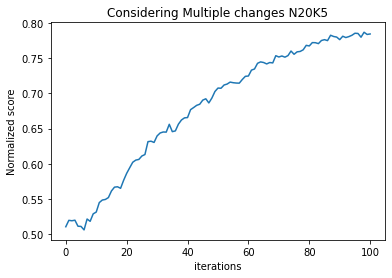

In [55]:
plt.plot(score_tracker.mean(axis=0))
plt.xlabel("iterations")
plt.ylabel("Normalized score")
plt.title(f"Considering Multiple changes (N{N}K{K})")

## Information sharing (Collective Search)

#### Agents Features
* **Information distribution for agents**
Agents have a personality feature which corresponds to the bits they are can change $\rho \in [0,1]$ sampled from $\mathbf{U}(0,1)$. The bit is sampled from $\mathbf{N}(\rho, 0.2)$, rounded and multiplied by 10. This means with $\rho = 0.2$ a gaussian with mean 0.2 is sampled and the result (likely 0.2) is used to define the bit (which would be 2)


* **Communication ability**
Agents have a feature $\gamma$ which is the probability of receiving information about the proposed change of another agent. This means agents with high $\gamma$ have more knowledge of possible improvements.


* **Performance Judgement**
Additional every agent has an attribute $\eta$ which models the competency of leading. After agents collect their information they assess which change they would propose if they are to decide the change. Some exploit their knowledge and choose the best, whereas others may have the information but do not know how to use it.


* **Creativity**
Agents take its received solutions and recombines them to search for even better solutions (instead of one bit switch there are two)



#### Schedule Overview
1. Individual optimization
2. Information sharing
3. Collective decision making
4. Solution implementation
5. Social influence: value function approximation

**Individual Optimization**
- Stochatic Hill Climbing with inverse temperature

**Leadership granting for social influence**
- Talkativness; Communication quality/ quantity
- Skill
- Credebility
- Self-esteem
- Intelligence

Implementation Steps:
* [x] Agents draw a change randomly and softmax over the solutions decide which one gets picked
* [x] Add communication feature and always draw the same agent (n-1 agents random feature, 1 agent set high or low)
    * Feature: Probability of receiving information
    * [x] Check difference in performance between high and low feature agent 
(* [x] Test Skill feature as well)
* [x] Introduce weights to estimate social influence
    * [ ] Add feature based RL
    * [ ] Unbounded/ Bounded RL
* [x] Linear function approximation - gradient based (CCN)
* [ ] Introduce information distribution based on feature

###### Load nk landscapes form file

In [18]:
# file = 'N10K5_30.pkl' # N=10, K=5, 30 landscapes (0-29 )
file = 'N20K5_5.pkl'
with open(file, 'rb') as f:
    landscapes = pickle.load(f)
n_landscapes = int(str(file.split("_")[1]).split(".")[0])
N, K = str(file.split("_")[0])[1:].split("K")
N, K = int(N), int(K)

### Test: Communication probability (gamma)

In [265]:
def run_gamma(env, gamma_i, iterations, rng):
    """Test if Communication feature makes a difference in performance"""
    # Initialize solution
    state = np.round(rng.random(env.N)).astype(int)
    score = env.get_scaled_fitness(state)
    state, score


    all_scores = np.empty(iterations+1)
    all_scores[0] = score
    
    agents_index = np.arange(n_agents)
    

    for i in range(iterations):
        # Changes of agents
        digits = rng.integers(0, N, n_agents)

        # Evaluation
        search_states = np.array([bit_switch(digit, state.copy()) for digit in digits])
        scores = np.array([env.get_scaled_fitness(search_state) for search_state in search_states])
        
        # Communication
        communication_index = rng.random(n_agents) <= gamma_i
        scores = scores[communication_index]
        search_states = search_states[communication_index]
        
        if len(scores) == 0:
            all_scores[i+1] = score
            continue
        
        # Same agent draws from its solutions
        p_proposals = softmax(scores, ((i+1)/iterations)*30 )
        change_digit = rng.choice(np.arange(len(scores)), p=p_proposals)

        # if scores[change_digit] >= score:
        state = search_states[change_digit]
        score = scores[change_digit]

        all_scores[i+1] = score
    
    return all_scores


In [267]:
rng = np.random.default_rng(0)
iterations = 100
n_trials = 500

n_agents = 7

# Communication feature of one agent
gamma_high = 0.8
gamma_low = 0.2
score_gamma_high = np.empty((n_trials, iterations+1))
score_gamma_low = np.empty((n_trials, iterations+1))


for i in range(n_trials):
    env = NK_landscape_loaded(N, K, landscapes[rng.integers(0 ,n_landscapes)])
    
    score_gamma_high[i] = run_gamma(env, gamma_high, iterations, rng)
    score_gamma_low[i] = run_gamma(env, gamma_low, iterations, rng)
    if i%100 == 0:
        print(i)
     

0
50
100
150
200
250
300
350
400
450


Text(0.5, 1.0, 'Team Perfomance - Decider receives options with with P=gamma (N20K5)')

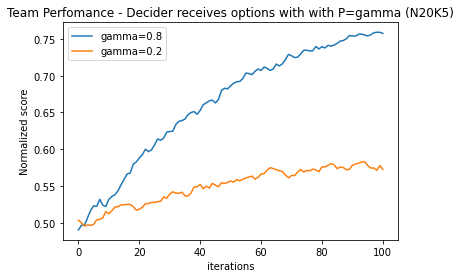

In [268]:
plt.plot(score_gamma_high.mean(axis=0), label="gamma=0.8")
plt.plot(score_gamma_low.mean(axis=0), label="gamma=0.2")
plt.legend()
plt.xlabel("iterations")
plt.ylabel("Normalized score")
plt.title(f"Perfomance - Decider receives options with with P=gamma (N{N}K{K})")

### Test: Exploitation of options (t)

In [90]:
def run_gamma_t(env, gamma_i, t_i, iterations, rng):
    """Test if Communication feature makes a difference in performance"""
    # Initialize solution
    state = np.round(rng.random(env.N)).astype(int)
    score = env.get_scaled_fitness(state)
    state, score


    all_scores = np.empty(iterations+1)
    all_scores[0] = score
    
    agents_index = np.arange(n_agents)
    

    for i in range(iterations):
        # Changes of agents
        digits = rng.integers(0, N, n_agents)

        # Evaluation
        search_states = np.array([bit_switch(digit, state.copy()) for digit in digits])
        scores = np.array([env.get_scaled_fitness(search_state) for search_state in search_states])
        
        # Communication
        communication_index = rng.random(n_agents) <= gamma_i
        scores = scores[communication_index]
        search_states = search_states[communication_index]
        
        if len(scores) == 0:
            all_scores[i+1] = score
            continue
        
        # Same agent draws from its solutions
        p_proposals = softmax(scores, ((i+1)/iterations) * t_i) # ((i+1)/iterations)*30 )
        change_digit = rng.choice(np.arange(len(scores)), p=p_proposals)

        # if scores[change_digit] >= score:
        state = search_states[change_digit]
        score = scores[change_digit]

        all_scores[i+1] = score
    
    return all_scores


In [92]:
rng = np.random.default_rng(1)
iterations = 80
n_trials = 500

n_agents = 7


# Communication feature of one agent
gamma = 0.8
t_low = 5
t_high = 20
score_t_high = np.empty((n_trials, iterations+1))
score_t_low = np.empty((n_trials, iterations+1))

print("Start")
for i in range(n_trials):
    env = NK_landscape_loaded(N, K, landscapes[rng.integers(0, n_landscapes)])

    score_t_high[i] = run_gamma_t(env, gamma, t_high, iterations, rng)
    score_t_low[i] = run_gamma_t(env, gamma, t_low, iterations, rng)
    if i%50 == 0:
        print(i)
print("End")

Start
0
50
100
150
200
250
End


Text(0.5, 1.0, 'Team Perfomance - Inv. Temp of decider (gamma=0.8) (N20K5)')

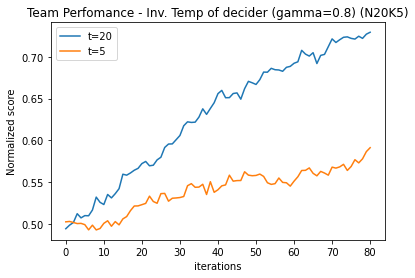

In [93]:
plt.plot(score_t_high.mean(axis=0), label="t=20")
plt.plot(score_t_low.mean(axis=0), label="t=5")
plt.legend()
plt.xlabel("iterations")
plt.ylabel("Normalized score")
plt.title(f"Team Perfomance - Inv. Temp of decider (gamma=0.8) (N{N}K{K})")

### Test: Interplay of gamma and t

In [94]:
rng = np.random.default_rng(1)
iterations = 80
n_trials = 500

n_agents = 7


# Communication feature of one agent
results = np.empty((n_trials, 3))
print("Start")
for i in range(n_trials):
    env = NK_landscape_loaded(N, K, landscapes[rng.integers(0, n_landscapes)])
    
    gamma = rng.random()
    t = 20 * rng.random()
    
    run_scores = run_gamma_t(env, gamma, t, iterations, rng)
    
    results[i] = [gamma, t, run_scores.mean()]
    
    if i%100 == 0:
        print(i)
print("End")

Start
0
100
200
300
400
End


Corr gamma and mean:  (0.3577167045426015, 1.5390354787867202e-16)
Corr t and mean:  (0.46231082603602336, 7.624482341977396e-28)
Corr gamma*t and mean:  (0.5977085582882825, 9.475876070917224e-50)


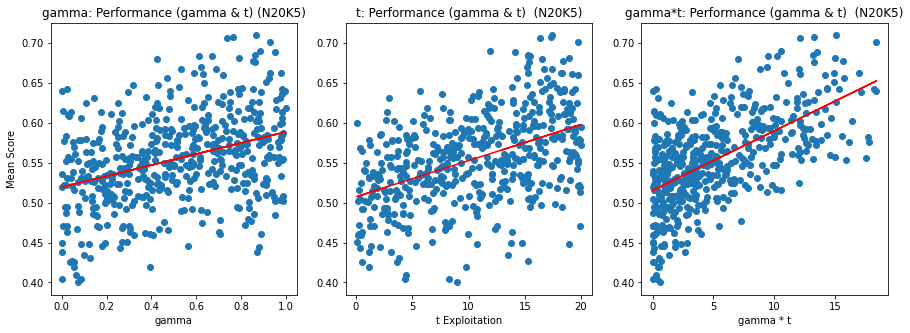

In [95]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

x = results[:,0]
y = results[:,2]
print("Corr gamma and mean: ", pearsonr(x, y))
axs[0].scatter(x, y)
m, c = np.polyfit(x, y, 1)
axs[0].plot(x, m*x + c, 'r', label='Fitted line')
axs[0].set_xlabel("gamma")
axs[0].set_ylabel("Mean Score")
axs[0].set_title(f"gamma: Performance (gamma & t) (N{N}K{K})")


x = results[:,1]
y = results[:,2]
print("Corr t and mean: ", pearsonr(x, y))
axs[1].scatter(x, y)
m, c = np.polyfit(x, y, 1)
axs[1].set_xlabel("t Exploitation")
axs[1].set_title(f"t: Performance (gamma & t)  (N{N}K{K})")
axs[1].plot(x, m*x + c, 'r')


x = results[:,0] * results[:,1]
y = results[:,2]
print("Corr gamma*t and mean: ", pearsonr(x, y))
axs[2].scatter(x, y)
m, c = np.polyfit(x, y, 1)
axs[2].set_xlabel("gamma * t")
axs[2].set_title(f"gamma*t: Performance (gamma & t)  (N{N}K{K})")
axs[2].plot(x, m*x + c, 'r')

### Result of feature selection

* Random exploration (with P=0.2) worsens the performance (results in file: NK landscapes)


* Communication probability gamma: positive correlated to performance


* Exploitation of options t: Also positive correlated to performance (with th assumption of a big choice)


* &rarr; Communication probability & Exploitation together weaken, but work together

## Learning of social influence

##### Algorithms
* ICA: Independent Component Analysis
    * Does not apply here. It can figure out source signals if a signal consists of different independent sources. in our case the performance does not directly consist of the features. The features only correlate to the performance.
   
   
* RW Learning + Softmax: Voting for an Agent is like choosing an action
    * Simplest approach
    * No feature weights


* Feature based RL: Proposed by Charley https://www.jneurosci.org/content/35/21/8145.full#F1
    * Paper: The value of an object consists of its features (shape: circle or rectangle, colour: blue, red, ...)
    * Updates weights for each feature based on observations
    * Problem: Features here are $\in U(0,1)$ and not {x, y, z}
        * Potential solution: Create bins low-mid-high and learn weights for them
    * Paper: Task 9 feature (3x3) -> 3 options of combinations given. If chosen correctly reward = 1 else 0
        * Also has a Baysian approach


* Value Function approximation:
    * CCN Solution
    * Label (see section):
        * Performance
            * Only one agent
            * Difference in Performance (Agents have access to everyones performance)
    * May fits theory nicely: Real world humans often learn value functions as well 


* Baysian Approaches:
    * Possibility of biased prior
    * Bayesian Inference
    * Baysian Linear Regression
        * not a Baysian method but maybe useful
    * Baysian RL


* Actor Critic RL Method


---

* Other metrics:
    * Use the previous number of votes (if someone was chose often more likely to be choen again)
    * Some probability approach (of having a better solution then average)
    

### RL with RW-Learning

In [291]:
def run_RWL_voting(env, gammas, iterations, rng):
    """Test if Communication feature makes a difference in performance"""
    # Initialize solution
    state = np.round(rng.random(env.N)).astype(int)
    score = env.get_scaled_fitness(state)
    state, score


    all_scores = np.empty(iterations+1)
    all_scores[0] = score
    
    agents_index = np.arange(n_agents)
    
    t = 30
    social_influence = np.zeros((n_agents, n_agents))

    for i in range(iterations):
        # Changes of agents
        digits = rng.integers(0, N, n_agents)

        # Evaluation
        search_states = np.array([bit_switch(digit, state.copy()) for digit in digits])
        scores = np.array([env.get_scaled_fitness(search_state) for search_state in search_states])
        
        # Communication
        all_agent_scores = dict()
        all_agent_states = dict()
        for agent_i in range(n_agents):
            communication_index = rng.random(n_agents) <= gammas[agent_i]
            all_agent_scores[agent_i] = scores[communication_index]
            all_agent_states[agent_i] = search_states[communication_index]
        
        # Vote # TODO sofmax along axis
        p_votings = softmax(social_influence, 5, axis=1) # TODO: Which exploitation to use?
        votes = []
        for p in p_votings:
            votes.append(rng.choice(np.arange(n_agents), p=p))
        
        vote_agent_index, vote_count = np.unique(np.array(votes), return_counts=True)
        speaker = list(vote_count).index(max(vote_count))        # TODO: Always returns first index (if tie always the same gets chosen)
        
        # Applying solution
        if len(all_agent_scores[speaker]) == 0:
            social_influence[:,speaker] = social_influence[:,speaker] + 0.2 * (score * 0.9 - score)
            all_scores[i+1] = score
            continue
        
        # Speaker draws from its known solutions
        scores = all_agent_scores[speaker]
        p_proposals = softmax(scores, ((i+1)/iterations) * t)
        change_digit = rng.choice(np.arange(len(scores)), p=p_proposals)

        # Update social influence
        
        social_influence[:,speaker] = social_influence[:,speaker] + 0.2 * (scores[change_digit] - score)
        
        state = all_agent_states[speaker][change_digit]
        score = scores[change_digit]
        
        
        all_scores[i+1] = score
    
    return social_influence.mean(axis=0)


In [302]:
rng = np.random.default_rng(1)
iterations = 80
n_trials = 500
n_agents = 7

# Communication feature of one agent
results = np.empty((n_trials*n_agents, 2))


print("Start")
for i in range(n_trials):
    env = NK_landscape_loaded(N, K, landscapes[rng.integers(0, n_landscapes)])
    
    gammas = rng.random(n_agents)
    social_influence = run_RWL_voting(env, gammas, iterations, rng)
    
    results[i*n_agents : i*n_agents + n_agents][:,0] = gammas
    results[i*n_agents : i*n_agents + n_agents][:,1] = social_influence 
    
    if i%100 == 0:
        print(i)
print("End")

Start
0
100
200
300
400
End


(0.5324635250104425, 1.4390258765586134e-255)


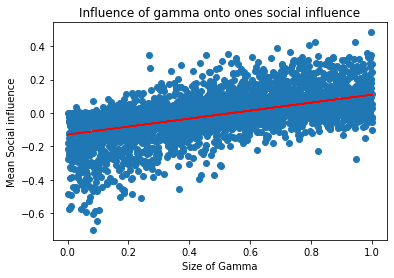

In [303]:
x = results[:,0]
plt.scatter(x, results[:,1])
m, c = np.polyfit(x,  results[:,1], 1)
plt.title(f"Influence of gamma onto ones social influence (N{N}K{K})")
plt.plot(x, m*x + c, 'r')
plt.xlabel("Size of Gamma")
plt.ylabel("Mean Social influence")
print(pearsonr(x, results[:,1]))

### Linear Value Function approximation

* TODO: Weights converge to same value for all agents


Ideas:
* Add a 1 to the states to capture such biases (Bias weight is just for RL)
    

In [128]:
def init_weights(f, score, n_agents, n_features, rng):
    """sample from gauß with mean for perfect estimation"""
    w = np.ones(n_features) * ((score/n_features) / f.mean())
    return rng.normal(w, 0.01, (n_agents, n_features))

def speaker_gradients(w, f_i, new_score):
    """
    Derivative of Mean Squared Error
    f_i: features of speaker
    w: Weights
    """
    dL = -(new_score - w@f_i).reshape(-1,1) * f_i
    return dL



In [260]:
def run_Regression_voting(env, f, iterations, n_features, rng):
    """Test if Communication feature makes a difference in performance"""
    # Initialize solution
    state = np.round(rng.random(env.N)).astype(int)
    score = env.get_scaled_fitness(state)
    
    gammas = f[:,0]
    etas = f[:,1] * 15
    # w = init_weights(f, score, n_agents, n_features, rng)
    w = rng.normal(0, 0.2, (n_agents, n_features))
    
    score_tracker = np.empty(iterations+1)
    score_tracker[0] = score
    
    weight_tracker = np.zeros((iterations+1, n_features))
    weight_tracker[0] = w.mean(axis=0)
    
    agents_index = np.arange(n_agents)
    
    for i in range(iterations):
        social_influence = np.inner(w, f)
        
        # Changes of agents
        digits = rng.integers(0, N, n_agents)
        
        # Evaluation
        search_states = np.array([bit_switch(digit, state.copy()) for digit in digits])
        scores = np.array([env.get_scaled_fitness(search_state) for search_state in search_states])
        
        # Communication
        all_agent_scores = dict()
        all_agent_states = dict()
        for agent_i in range(n_agents):
            # all_agent_scores[agent_i] = np.array([scores[agent_i]])
            # all_agent_states[agent_i] = np.array([search_states[agent_i]])
            
            communication_index = rng.random(n_agents) <= gammas[agent_i]
            all_agent_scores[agent_i] = scores[communication_index]
            all_agent_states[agent_i] = search_states[communication_index]
            # all_agent_scores[agent_i] = np.extend(all_agent_scores[agent_i], scores[communication_index])
            # all_agent_states[agent_i] = np.extend(all_agent_states[agent_i], search_states[communication_index])

        # Vote
        p_votings = softmax(social_influence, 5, axis=1) # TODO: Which exploitation to use?
        votes = []
        for p in p_votings:
            votes.append(rng.choice(np.arange(n_agents), p=p))
        
        vote_agent_index, vote_count = np.unique(np.array(votes), return_counts=True)
        speaker = list(vote_count).index(max(vote_count))        # TODO: Always returns first index (if tie always the same gets chosen)
        
        if len(all_agent_scores[speaker]) == 0:
            all_agent_scores[speaker] = np.array([scores[speaker]])
            all_agent_states[speaker] = np.array([search_states[speaker]])

        
        # Speaker draws from its known solutions
        scores = all_agent_scores[speaker]
        p_proposals = softmax(scores, ((i+1)/iterations) * etas[speaker])
        change_digit = rng.choice(np.arange(len(scores)), p=p_proposals)
        
        # Update social influence (value function approximation)
        lr = 0.1
        v = (scores[change_digit] - score) * 10  # Value to learn
        # v = scores[change_digit]
        
        gradients = speaker_gradients(w, f[speaker], v)
        w -= lr * gradients 
        
        state = all_agent_states[speaker][change_digit]
        score = scores[change_digit]
        
        score_tracker[i+1] = score
        weight_tracker[i+1] = w.mean(axis=0)
        
    return social_influence.mean(axis=0), w.mean(axis=0), weight_tracker, score_tracker


In [263]:
rng = np.random.default_rng(1)
iterations = 100
n_trials = 500

n_agents = 7

n_features = 4

# Communication feature of one agent
results = np.empty((n_trials*n_agents, n_features*2+1))

all_weights = np.zeros((iterations+1, n_features))
all_scores  = np.zeros(iterations+1)

print(f"Start (N{N}K{K})")
for i in range(n_trials):
    env = NK_landscape_loaded(N, K, landscapes[rng.integers(0, n_landscapes)])
    
    f = rng.random((n_agents, n_features))
    social_influence, w, weight_tracker, score_tracker = run_Regression_voting(env, f, iterations, n_features, rng)
    
    results[i*n_agents : i*n_agents + n_agents][:,0:n_features]  = f
    results[i*n_agents : i*n_agents + n_agents][:,n_features]    = social_influence 
    results[i*n_agents : i*n_agents + n_agents][:,n_features+1:] = w 
    
    all_weights += weight_tracker
    all_scores  += score_tracker
    
    if (i+1)%100 == 0:
        print(i+1)
    
all_weights = all_weights/n_trials
all_scores  = all_scores/n_trials

print("End")

Start (N20K5)
100
200
300
400
500
End


Correlation of social influence and gamma: 0.1631
Correlation of social influence and eta: 0.2163
Correlation of social influence and f#1: -0.1101
Correlation of social influence and f#2: -0.0958
Correlation of social influence and gamma*eta: 0.2894


Text(0.5, 1.0, 'Score over time')

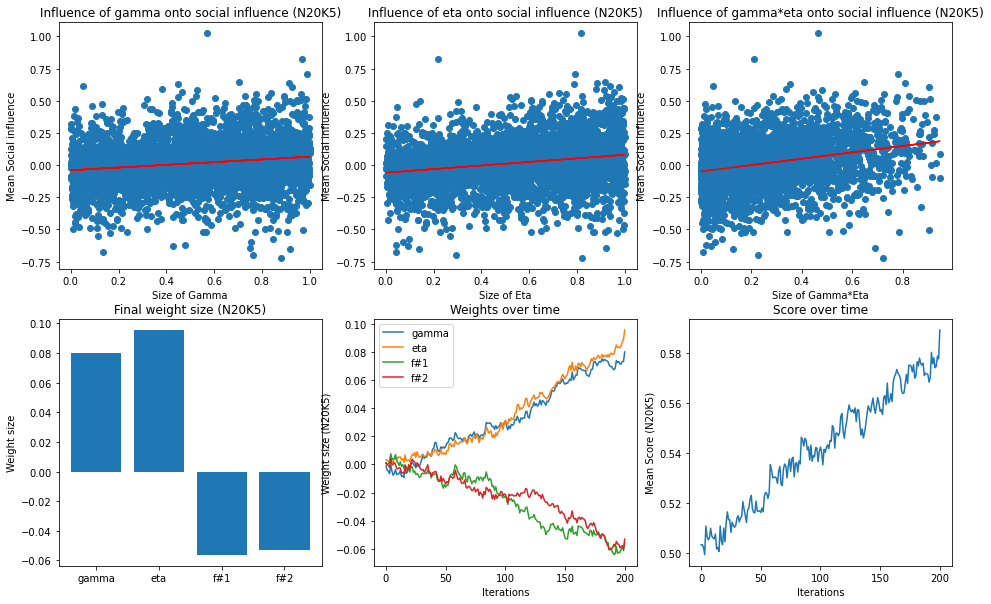

In [264]:
fig, axs = plt.subplots(2,3, figsize=(16, 10))

labels  = ["gamma", "eta"]
labels.extend([f"f#{_+1}" for _ in range(n_features-2)])
for i in range(len(labels)):
    print(f"Correlation of social influence and {labels[i]}:", pearsonr(results[:,i], results[:,n_features])[0].round(4))


# Correlation_plots
x = results[:,0]
axs[0,0].scatter(x, results[:,n_features])
m, c = np.polyfit(x,  results[:,n_features], 1)
axs[0,0].set_title(f"Influence of gamma onto social influence (N{N}K{K})")
axs[0,0].plot(x, m*x + c, 'r')
axs[0,0].set_xlabel("Size of Gamma")
axs[0,0].set_ylabel("Mean Social influence")

x = results[:,1]
axs[0,1].scatter(x, results[:,n_features])
m, c = np.polyfit(x,  results[:,n_features], 1)
axs[0,1].set_title(f"Influence of eta onto social influence (N{N}K{K})")
axs[0,1].plot(x, m*x + c, 'r')
axs[0,1].set_xlabel("Size of Eta")
axs[0,1].set_ylabel("Mean Social influence")

x = results[:,0] * results[:,1]
axs[0,2].scatter(x, results[:,n_features])
m, c = np.polyfit(x,  results[:,n_features], 1)
axs[0,2].set_title(f"Influence of gamma*eta onto social influence (N{N}K{K})")
axs[0,2].plot(x, m*x + c, 'r')
axs[0,2].set_xlabel("Size of Gamma*Eta")
axs[0,2].set_ylabel("Mean Social influence")
print(f"Correlation of social influence and gamma*eta:", pearsonr(x, results[:,n_features])[0].round(4))


# Weight size
axs[1,0].bar(x=labels, height=results[:,n_features+1:].mean(axis=0))
axs[1,0].set_title(f"Final weight size (N{N}K{K})")
axs[1,0].set_ylabel("Weight size");

# Weights over time
[axs[1,1].plot(all_weights[:,i], label=labels[i]) for i in range(len(labels))]
axs[1,1].legend()
axs[1,1].set_xlabel("Iterations")
axs[1,1].set_ylabel(f"Weight size (N{N}K{K})")
axs[1,1].set_title("Weights over time")

# Score over time
axs[1,2].plot(all_scores)
axs[1,2].set_xlabel("Iterations")
axs[1,2].set_ylabel(f"Mean Score (N{N}K{K})")
axs[1,2].set_title("Score over time")

In [256]:
# Mean score (based on learned weights)
results[:,n_features+1:].mean(axis=0) @ results[:,0:n_features].mean(axis=0)

0.5212060500753379

##### Label ideas:
Every algorithm needs some form of prediction error. How to measure the value of an agent?

- The score itself
    - All weights are highly positive as all features are needed to get the performance measure
    - Use bias neuron (f#0 = 1)
- The difference to the previous score
    - extremly small value
    - Scaling it higher?
- Every agent compares the voted answer with its own best possible answer
    - Good agents don't vote others
    - Bad ones don't vote for themselves


## Collective Decision Making 

In this case a leader needs to propose a solution to have an efficient system.
Team should not discuss it, but has a distinct communication phase
Voting seems to be a reasonable and realistic choice. Alternatively some for agreement scales 

Followers grant leaders influence onto their social behaviour.

Attributes usually mentioned with decision making
- Credebility
- Confidence